Importing Required Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib


Loading and Exploring the PTSD Dataset & Label Encoding for Categorical Variables

In [2]:
# Load Excel file
file_path = 'C:\\Users\\sanskruti\\OneDrive\\Desktop\\Ptsd risk prediction anaysis.xlsx'
xls = pd.ExcelFile(file_path)

# Load the dataset from the correct sheet
df = xls.parse('PTSD_Risk_Prediction_Dataset')

# Drop non-informative columns
df_clean = df.drop(columns=['Soldier_ID'])

# Encode categorical columns using LabelEncoder
label_encoders = {}
for column in df_clean.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_clean[column] = le.fit_transform(df_clean[column])
    label_encoders[column] = le


Splitting the Dataset into Training and Testing Sets

In [3]:
X = df_clean.drop(columns=['PTSD_Risk_Level'])  # Features
y = df_clean['PTSD_Risk_Level']  # Target


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


Training a Random Forest Classifier Model

In [6]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

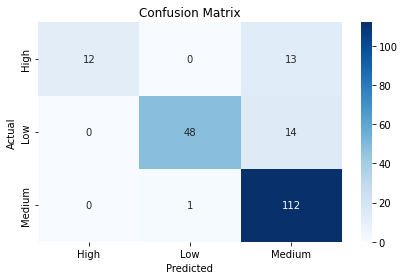

In [7]:
y_pred = model.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoders['PTSD_Risk_Level'].classes_,
            yticklabels=label_encoders['PTSD_Risk_Level'].classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Evaluating the Model Performance

In [8]:
# Classification Report
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       1.00      0.48      0.65        25
           1       0.98      0.77      0.86        62
           2       0.81      0.99      0.89       113

    accuracy                           0.86       200
   macro avg       0.93      0.75      0.80       200
weighted avg       0.88      0.86      0.85       200



Model Evaluation Using Cross-Validation

In [9]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 2: Evaluate on test set (Optional)
y_pred = rf.predict(X_test)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5)

print("Cross-Validation Scores (5-fold):", cv_scores)
print("Mean Accuracy:", round(cv_scores.mean(), 4))
print("Standard Deviation:", round(cv_scores.std(), 4))


Cross-Validation Scores (5-fold): [0.915 0.89  0.86  0.865 0.89 ]
Mean Accuracy: 0.884
Standard Deviation: 0.0198


Plotting feature importance 

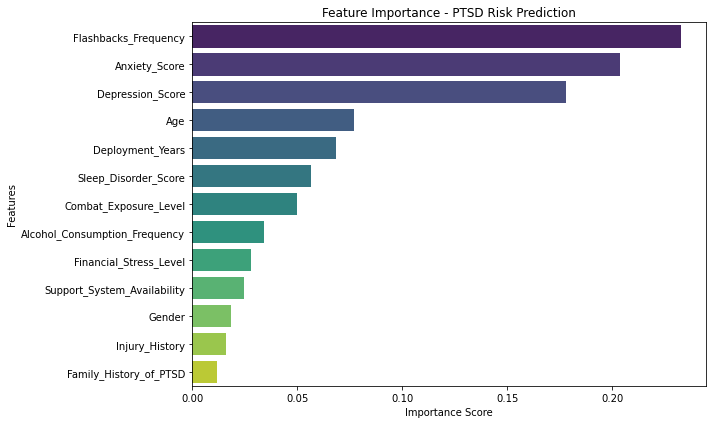

In [10]:
importances = rf.feature_importances_
features = X.columns
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
plt.title('Feature Importance - PTSD Risk Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


Saving the models and encoders for further prediction

In [11]:
joblib.dump(model, 'ptsd_model.pkl')
joblib.dump(scaler, 'ptsd_scaler.pkl')
joblib.dump(label_encoders, 'ptsd_label_encoders.pkl')


['ptsd_label_encoders.pkl']

Making Predictions on New Data

In [12]:
# Step 1: Load trained model, scaler, encoders 
model = joblib.load('ptsd_model.pkl')
scaler = joblib.load('ptsd_scaler.pkl')
label_encoders = joblib.load('ptsd_label_encoders.pkl')

In [13]:
# Step 2: Load new data from Excel file 
file_path = 'C:\\Users\\sanskruti\\OneDrive\\Desktop\\Soldier.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Step 3: Keep Soldier_ID separately for reference 
soldier_ids = df['Soldier_ID']

# Step 4: Drop non-informative or unnecessary columns 
df_clean = df.drop(columns=['Soldier_ID'])

# Step 5: Encode categorical columns using saved encoders 
for col in df_clean.columns:
    if col in label_encoders:
        le = label_encoders[col]
        df_clean[col] = le.transform(df_clean[col])

In [14]:
# Step 6: Drop target column if exists (in case you're predicting) 
if 'PTSD_Risk_Level' in df_clean.columns:
    df_clean = df_clean.drop(columns=['PTSD_Risk_Level'])

# Step 7: Scale features 
X_scaled = scaler.transform(df_clean)

# Step 8: Make predictions 
predictions = model.predict(X_scaled)


In [15]:
# Step 9: Decode predictions (if encoder was used on target)
risk_labels = label_encoders['PTSD_Risk_Level'].inverse_transform(predictions)

# Step 10: Combine predictions with original data
df['Predicted_Risk_Level'] = risk_labels

# Step 11: Save predictions to new Excel file
output_file = 'C:\\Users\\sanskruti\\OneDrive\\Desktop\\PTSD_Predictions_Output.xlsx'
df.to_excel(output_file, index=False)

print("Predictions saved to:", output_file)


Predictions saved to: C:\Users\sanskruti\OneDrive\Desktop\PTSD_Predictions_Output.xlsx


Filtering High-Risk Soldiers for Alerts

In [16]:
#Step 7: AUTOMATED ALERT SYSTEM 

# Define alert categories
alert_levels = ['High', 'Severe']

# Filter for high-risk soldiers
alert_df = df[df['Predicted_Risk_Level'].isin(alert_levels)]

if not alert_df.empty:
    print("ALERT: High PTSD Risk Detected for the following soldiers:")
    print(alert_df[['Soldier_ID', 'Predicted_Risk_Level']])

    # Save alerts to a separate file
    alert_output = 'C:\\Users\\sanskruti\\OneDrive\\Desktop\\PTSD_Alerts.xlsx'
    alert_df.to_excel(alert_output, index=False)
    print(f" Alert report saved to: {alert_output}")
else:
    print(" No high-risk cases found in this batch.")


ALERT: High PTSD Risk Detected for the following soldiers:
    Soldier_ID Predicted_Risk_Level
1        S0002                 High
4        S0005                 High
8        S0009                 High
19       S0020                 High
27       S0028                 High
..         ...                  ...
922      S0923                 High
936      S0937                 High
943      S0944                 High
966      S0967                 High
972      S0973                 High

[101 rows x 2 columns]
 Alert report saved to: C:\Users\sanskruti\OneDrive\Desktop\PTSD_Alerts.xlsx


Email Alert Setup for High PTSD Risk Soldiers

In [17]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

In [18]:
# Load your predicted dataset
df = pd.read_excel('C:\\Users\\sanskruti\\OneDrive\\Desktop\\PTSD_Predictions_Output.xlsx')  

# Filter only High PTSD Risk
high_risk_df = df[df['Predicted_Risk_Level'] == 'High']

if not high_risk_df.empty:
    # Extract only Soldier_IDs
    soldier_ids = high_risk_df['Soldier_ID'].tolist()
    soldier_ids_str = "\n".join(str(sid) for sid in soldier_ids)

    # Email setup
    sender_email = "sanskrutipasalkar10@gmail.com"
    receiver_email = "sanskrutipasalkar2@gmail.com"
    app_password = "ydgo hcgt kydl ohac"  # App password

    # Email content
    subject = "High PTSD Risk Alert - Soldiers Identified"
    body = "The following Soldier_IDs are predicted to have HIGH PTSD Risk:\n\n"
    body += soldier_ids_str

    # Create email
    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = receiver_email
    message["Subject"] = subject
    message.attach(MIMEText(body, "plain"))

    # Send email
    try:
        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
            server.login(sender_email, app_password)
            server.send_message(message)
        print("Email alert sent successfully!")
    except Exception as e:
        print("Error sending email:", e)
else:
    print("No high-risk soldiers found. No email sent.")


Email alert sent successfully!
